In [1]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from paddle.io import Dataset


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

In [2]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                              #输入图片的shape
    "class_dim": -1,                                          #分类数
    "src_path":"/home/aistudio/data/data55190/Chinese Medicine.zip",    #原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 1,                                         #训练轮数
    "train_batch_size": 8,                                    #训练时每个批次的大小
    "skip_steps": 10,
    "save_steps": 30, 
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.0001                                          #超参数学习率
    },
    "checkpoints": "/home/aistudio/work/checkpoints"          #保存的路径

}

# **一、数据准备**

（1）解压原始数据集

（2）按照比例划分训练集与验证集

（3）乱序，生成数据列表

（4）定义数据读取器

In [3]:
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "Chinese Medicine")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [4]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"Chinese Medicine/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别，['river', 'lawn','church','ice','desert']
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 8 == 0:                                  # 每8张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
  
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [5]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

生成数据列表完成！


In [6]:
class dataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [7]:

#训练数据加载
train_dataset = dataset('/home/aistudio/data',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)
#测试数据加载
eval_dataset = dataset('/home/aistudio/data',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [8]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 /home/aistudio/data/Chinese Medicine/huaihua/huaihua_176.jpg 	标签值 0
787
文件名 /home/aistudio/data/Chinese Medicine/jinyinhua/jyh_148.jpg 	标签值 1
115
(3, 224, 224)
(1,)


# **二、模型配置**

![](https://ai-studio-static-online.cdn.bcebos.com/9ca0744272b0449186f766afcabadd598e24679088a4438dafede05a71b7c141)

VGG的核心是五组卷积操作，每两组之间做Max-Pooling空间降维。同一组内采用多次连续的3X3卷积，卷积核的数目由较浅组的64增多到最深组的512，同一组内的卷积核数目是一样的。卷积之后接两层全连 接层，之后是分类层。由于每组内卷积层的不同，有11、13、16、19层这几种模型，上图展示一个16层的网络结构。



In [9]:
# class ConvPool(paddle.nn.Layer):
#     '''卷积+池化'''
#     def __init__(self,
#                  num_channels,#1
#                  num_filters, #2
#                  filter_size,#3
#                  pool_size,#4
#                  pool_stride,#5
#                  groups,#6
#                  conv_stride=1, 
#                  conv_padding=1,
#                  ):
#         super(ConvPool, self).__init__()  

#         self._conv2d_list = []

#         for i in range(groups):
#             conv2d = self.add_sublayer(   #添加子层实例
#                 'bb_%d' % i,
#                 paddle.nn.Conv2D(         # layer
#                 in_channels=num_channels, #通道数
#                 out_channels=num_filters,   #卷积核个数
#                 kernel_size=filter_size,   #卷积核大小
#                 stride=conv_stride,        #步长
#                 padding = conv_padding,    #padding
#                 )
#             )
#             num_channels = num_filters
            
#             self._conv2d_list.append(conv2d)

#         self._pool2d = paddle.nn.MaxPool2D(
#             kernel_size=pool_size,           #池化核大小
#             stride=pool_stride               #池化步长
#             )
#         print(self._conv2d_list)
#     def forward(self, inputs):
#         x = inputs
#         for conv in self._conv2d_list:
#             x = conv(x)
#             x = paddle.nn.functional.relu(x)
#         x = self._pool2d(x)
#         return x
        

In [10]:
class ConvPool(paddle.nn.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,
                 num_filters, 
                 filter_size,
                 pool_size,
                 pool_stride,
                 groups,
                 conv_stride=1, 
                 conv_padding=1,
                 ):
        super(ConvPool, self).__init__()  


        for i in range(groups):
            self.add_sublayer(   #添加子层实例
                'bb_%d' % i,
                paddle.nn.Conv2D(         # layer
                in_channels=num_channels, #通道数
                out_channels=num_filters,   #卷积核个数
                kernel_size=filter_size,   #卷积核大小
                stride=conv_stride,        #步长
                padding = conv_padding,    #padding
                )
            )
            self.add_sublayer(
                'relu%d' % i,
                paddle.nn.ReLU()
            )
            num_channels = num_filters
            

        self.add_sublayer(
            'Maxpool',
            paddle.nn.MaxPool2D(
            kernel_size=pool_size,           #池化核大小
            stride=pool_stride               #池化步长
            )
        )

    def forward(self, inputs):
        x = inputs
        for prefix, sub_layer in self.named_children():
            # print(prefix,sub_layer)
            x = sub_layer(x)
        return x
        

In [11]:
class VGGNet(paddle.nn.Layer):
  
    def __init__(self):
        super(VGGNet, self).__init__()       
        self.convpool01 = ConvPool(
            3, 64, 3, 2, 2, 2)  #3:通道数，64：卷积核个数，3:卷积核大小，2:池化核大小，2:池化步长，2:连续卷积个数
        self.convpool02 = ConvPool(
            64, 128, 3, 2, 2, 2)
        self.convpool03 = ConvPool(
            128, 256, 3, 2, 2, 3) 
        self.convpool04 = ConvPool(
            256, 512, 3, 2, 2, 3)
        self.convpool05 = ConvPool(
            512, 512, 3, 2, 2, 3)       
        self.pool_5_shape = 512 * 7* 7
        self.fc01 = paddle.nn.Linear(self.pool_5_shape, 4096)
        self.fc02 = paddle.nn.Linear(4096, 4096)
        self.fc03 = paddle.nn.Linear(4096, train_parameters['class_dim'])

    def forward(self, inputs, label=None):
        # print('input_shape:', inputs.shape) #[8, 3, 224, 224]
        """前向计算"""
        out = self.convpool01(inputs)
        # print('convpool01_shape:', out.shape)           #[8, 64, 112, 112]
        out = self.convpool02(out)
        # print('convpool02_shape:', out.shape)           #[8, 128, 56, 56]
        out = self.convpool03(out)
        # print('convpool03_shape:', out.shape)           #[8, 256, 28, 28]
        out = self.convpool04(out)
        # print('convpool04_shape:', out.shape)           #[8, 512, 14, 14]
        out = self.convpool05(out)
        # print('convpool05_shape:', out.shape)           #[8, 512, 7, 7]         

        out = paddle.reshape(out, shape=[-1, 512*7*7])
        out = self.fc01(out)
        out = self.fc02(out)
        out = self.fc03(out)
        
        if label is not None:
            acc = paddle.metric.accuracy(input=out, label=label)
            return out, acc
        else:
            return out
            

# 三、模型训练 

In [12]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
print(train_parameters['class_dim'])
print(train_parameters['label_dict'])

5
{'0': 'huaihua', '1': 'jinyinhua', '2': 'dangshen', '3': 'baihe', '4': 'gouqi'}


W0113 19:04:52.206979    98 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W0113 19:04:52.212553    98 device_context.cc:372] device: 0, cuDNN Version: 7.6.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):


epo: 0, step: 10, loss is: [1.7799032], acc is: [0.1875]
epo: 0, step: 20, loss is: [1.9488264], acc is: [0.0625]
epo: 0, step: 30, loss is: [1.3869125], acc is: [0.8125]
save model to: /home/aistudio/work/checkpoints/save_dir_30.pdparams
epo: 0, step: 40, loss is: [1.1477336], acc is: [0.5]
epo: 0, step: 50, loss is: [1.4054787], acc is: [0.33333334]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


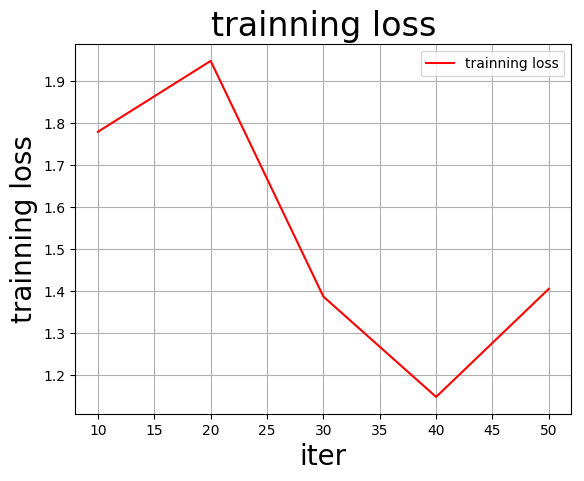

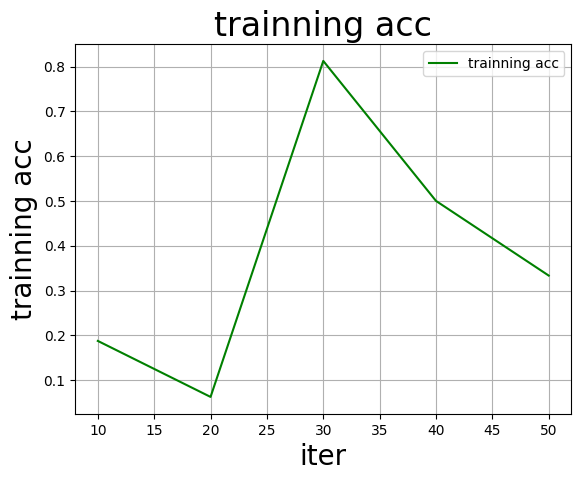

In [14]:
model = VGGNet()
model.train()
cross_entropy = paddle.nn.CrossEntropyLoss()
optimizer = paddle.optimizer.Adam(learning_rate=train_parameters['learning_strategy']['lr'],
                                  parameters=model.parameters()) 

steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(train_parameters['num_epochs']):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts, acc = model(x_data, y_data)
        loss = cross_entropy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))
        #保存模型参数
        if steps % train_parameters["save_steps"] == 0:
            save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + str(steps) + '.pdparams'
            print('save model to: ' + save_path)
            paddle.save(model.state_dict(),save_path)
paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

# 四、模型评估

In [15]:

'''
模型评估
'''
model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_eval = VGGNet()
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()
accs = []

for _, data in enumerate(eval_loader()):
    x_data = data[0]
    y_data = data[1]
    predicts = model_eval(x_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    accs.append(acc.numpy()[0])
print('模型在验证集上的准确率为：',np.mean(accs))

模型在验证集上的准确率为： 0.4138889


# **五、模型预测**

In [16]:
def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path + "Chinese Medicine Infer")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255 # HWC to CHW 及归一化
    return img


infer_src_path = '/home/aistudio/data/data55194/Chinese Medicine Infer.zip'
infer_dst_path = '/home/aistudio/data/'
unzip_infer_data(infer_src_path,infer_dst_path)

label_dic = train_parameters['label_dict']

In [17]:

model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_predict = VGGNet()
model_predict.set_state_dict(model__state_dict) 
model_predict.eval()
infer_imgs_path = os.listdir(infer_dst_path+"Chinese Medicine Infer")
print(infer_imgs_path)
for infer_img_path in infer_imgs_path:
    infer_img = load_image(infer_dst_path+"Chinese Medicine Infer/"+infer_img_path)
    infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,224,224)
    infer_img = paddle.to_tensor(infer_img)
    result = model_predict(infer_img)
    lab = np.argmax(result.numpy())
    print("样本: {},被预测为:{}".format(infer_img_path,label_dic[str(lab)]))

['dangshen01.jpg', 'jinyinhua02.jpg', 'huaihua01.jpg', 'gouqi02.jpg', 'jinyinhua01.jpg', 'gouqi01.jpg', 'baihe02.jpg', 'dangshen02.jpg', 'huaihua02.jpg', 'baihe01.jpg']
样本: dangshen01.jpg,被预测为:huaihua
样本: jinyinhua02.jpg,被预测为:huaihua
样本: huaihua01.jpg,被预测为:huaihua
样本: gouqi02.jpg,被预测为:gouqi
样本: jinyinhua01.jpg,被预测为:huaihua
样本: gouqi01.jpg,被预测为:gouqi
样本: baihe02.jpg,被预测为:huaihua
样本: dangshen02.jpg,被预测为:huaihua
样本: huaihua02.jpg,被预测为:huaihua
样本: baihe01.jpg,被预测为:jinyinhua
